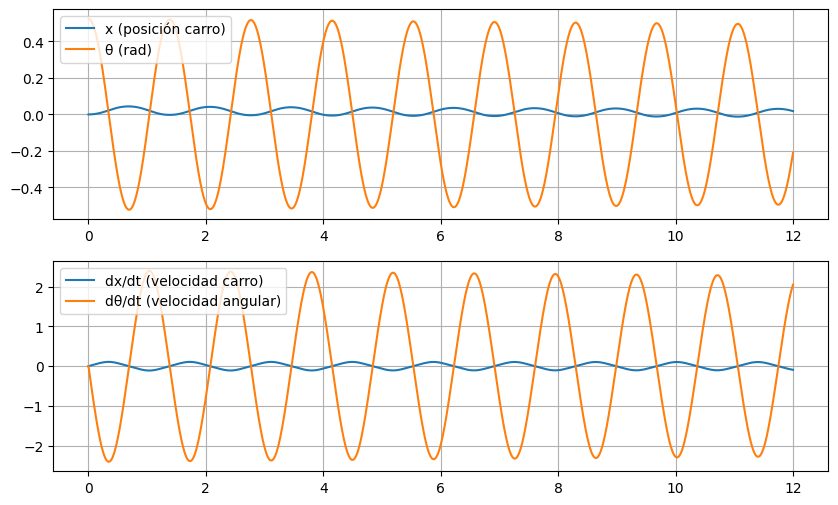

In [27]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Parámetros
M = 1.0   # masa del carro [kg]
m = 0.1   # masa del péndulo [kg]
l = 0.5   # longitud del péndulo [m]
b = 0.1   # fricción
g = 9.81  # gravedad

# Fuerza externa (puede ser constante o una función del tiempo)
def force(t):
    return 0.0  # sin fuerza externa

# Ecuaciones de estado
def dynamics(t, state):
    x, x_dot, theta, theta_dot = state
    F = force(t)

    # Construcción de ecuaciones
    denom = M + m*np.sin(theta)**2

    x_ddot = (F - b*x_dot + m*np.sin(theta)*(l*theta_dot**2 + g*np.cos(theta))) / denom
    theta_ddot = (-F*np.cos(theta) + b*x_dot*np.cos(theta) - (M+m)*g*np.sin(theta) 
                  - m*l*theta_dot**2*np.sin(theta)*np.cos(theta)) / (l*denom)

    return [x_dot, x_ddot, theta_dot, theta_ddot]

# Condiciones iniciales
state0 = [0.0, 0.0, np.pi/6, 0.0]  # x, dx, theta=30°, dtheta

# Tiempo de simulación
t_span = (0, 12)
t_eval = np.linspace(t_span[0], t_span[1], 2000)

# Resolver con Runge-Kutta
sol = solve_ivp(dynamics, t_span, state0, t_eval=t_eval, method='RK45')

# Graficar resultados
plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.plot(sol.t, sol.y[0], label="x (posición carro)")
plt.plot(sol.t, sol.y[2], label="θ (rad)")
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.plot(sol.t, sol.y[1], label="dx/dt (velocidad carro)")
plt.plot(sol.t, sol.y[3], label="dθ/dt (velocidad angular)")
plt.legend()
plt.grid()

plt.show()


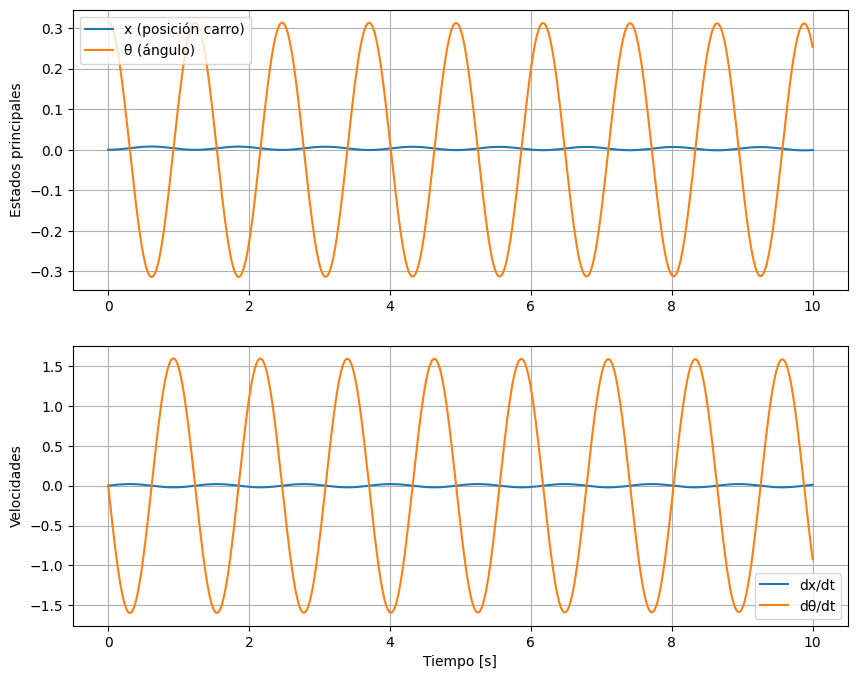

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from control import ss, forced_response, tf
from sympy import symbols, Matrix, sin, cos

# Parámetros físicos
M = 1.0    # masa carro
m = 0.1    # masa péndulo
L = 0.5    # longitud barra
b = 0.05   # fricción
g = 9.81
I_c = (1/12)*m*L**2   # inercia varilla en su CM
l = L/2               # distancia pivote–CM

# Variables simbólicas
x1, x2, x3, x4, u = symbols("x1 x2 x3 x4 u")

# Matriz de masas
D = Matrix([[M+m, m*l*cos(x3)],
            [m*l*cos(x3), I_c+m*l**2]])

# Vector de fuerzas generalizadas
rhs = Matrix([
    u - b*x2 + m*l*sin(x3)*x4**2,
    -m*g*l*sin(x3)
])

# Resolver [xddot, thetaddot]
xddot, thetaddot = D.LUsolve(rhs)

# Dinámica no lineal
f = Matrix([x2, xddot, x4, thetaddot])

# Jacobianos
A = f.jacobian([x1, x2, x3, x4])
B = f.jacobian([u])

# Función para linealizar
def linearize(point):
    subs_dict = {x1: point[0], x2: point[1], x3: point[2], x4: point[3], u: point[4]}
    A_num = np.array(A.subs(subs_dict), dtype=float)
    B_num = np.array(B.subs(subs_dict), dtype=float)
    C_num = np.eye(4)   # medimos todos los estados
    D_num = np.zeros((4,1))
    return ss(A_num, B_num, C_num, D_num)

# --- Linealización en péndulo hacia arriba (inestable) ---
sys_up = linearize([0, 0, np.pi/6, 0, 0])

# --- Simulación ---
T = np.linspace(0, 10, 2000)   # tiempo
U = np.zeros_like(T)         # entrada = 0 (libre)
X0 = [0.0, 0.0, np.pi/10, 0.0]    # perturbación inicial: theta = 0.1 rad

t, y = forced_response(sys_up, T, U, X0)

# --- Gráficas ---
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.plot(t, y[0], label="x (posición carro)")
plt.plot(t, y[2], label="θ (ángulo)")
plt.ylabel("Estados principales")
plt.legend(); plt.grid()

plt.subplot(2,1,2)
plt.plot(t, y[1], label="dx/dt")
plt.plot(t, y[3], label="dθ/dt")
plt.ylabel("Velocidades")
plt.xlabel("Tiempo [s]")
plt.legend(); plt.grid()

plt.show()



In [34]:
sol.y[1]

array([ 0.        ,  0.00248709,  0.00497287, ..., -0.08940403,
       -0.09091745, -0.0923595 ])